<h3 style="color:blue;"><b>DATA PRE-PROCESSING</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Load dataset
df = pd.read_excel('/Users/johnharmer/Library/CloudStorage/GoogleDrive-jwharmeriv@gmail.com/My Drive/Springboard - Data Science/Capstone Projects/Capstone 3/Customer Segmentation Project/data/raw/Online Retail.xlsx')

In [3]:
# Load 10 rows to review DataFrame.
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
# Check for missing values in df.
missing_values = df.isnull().sum()
missing_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# Drop rows with missing 'CustomerID'.
df = df.dropna(subset=['CustomerID'])

In [6]:
# Confirm missing values are removed from 'CustomerID'.
missing_values_clean = df.isnull().sum()
missing_values_clean

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
df.shape

(406829, 8)

In [8]:
# Check for duplicates
duplicates = df.duplicated().sum()

# Get data_types of each column.
data_types = df.dtypes

duplicates, data_types

(5225,
 InvoiceNo              object
 StockCode              object
 Description            object
 Quantity                int64
 InvoiceDate    datetime64[ns]
 UnitPrice             float64
 CustomerID            float64
 Country                object
 dtype: object)

In [9]:
# Remove duplicate rows from the df.
df = df.drop_duplicates()

# Confirum duplicate rows have been removed.
df_dedupe = df.shape

df_dedupe

(401604, 8)

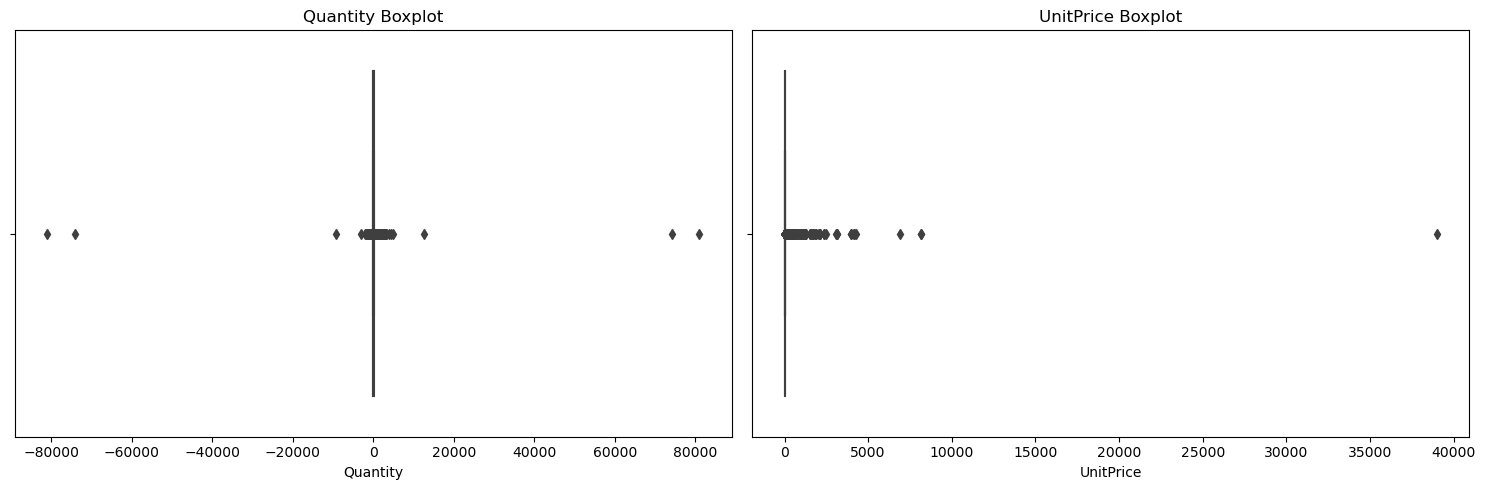

In [10]:
# Plot boxplots to visually identify outliers in 'Quantity' and 'UnitPrice'.
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['Quantity'])
plt.title('Quantity Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['UnitPrice'])
plt.title('UnitPrice Boxplot')

plt.tight_layout()
plt.show()

The negative quantities are associated with cancellations, so it is likely that these will be dropped. There is are also a few outliers for UnitPrice that need to be reviewed before taking any actions with them. In particular, the $39,000 outlier needs to be reviewed.

In [11]:
# Look for 'InvoiceNo' where it starts with "C" which indicates a cancellation.
# Filter the DataFrame to see all occurrences where 'InvoiceNo' starts with 'C', indicating a cancellation
cancellations = df[df['InvoiceNo'].astype(str).str.startswith('C')]

# Display the rows where 'InvoiceNo' indicates a cancellation
cancellations.shape

(8872, 8)

**Considerations for Removing Cancellations**

In RFM analysis, the goal is typically to understand a customer's value and engagement level. Cancellations are not representative of active engagement and can skew the understanding of customer loyalty or spending power. Removing cancellations ensures that only positive engagements (purchases) are considered, which provides a more accurate picture of a customer’s contribution to the business.

In [12]:
# Filter the DataFrame to exclude cancellations.
sales_only_df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [13]:
# Display shape of DataFrame with cancellations removed
sales_only_df.shape

(392732, 8)

It may be worth removing some StockCode's like *'D'* or *'M'*. Look for other unique StockCode's to see what others are there. I will also look to see what time of year the *'D'* (discounts) were offered to see if there is a seasonal trend.

In [14]:
# Separate 'InvoiceDate' into 'Date' and 'Time' using .loc to avoid SettingWithCopyWarning
sales_only_df.loc[:, 'Date'] = sales_only_df['InvoiceDate'].dt.date
sales_only_df.loc[:, 'Time'] = sales_only_df['InvoiceDate'].dt.time

# Drop 'InvoiceDate' column.
sales_only_df = sales_only_df.drop(columns=['InvoiceDate'])

# Display the first few rows to verify the changes
sales_only_df.head()

/var/folders/97/_c74g48s1xq_7yyvz41387qh0000gp/T/ipykernel_39906/2965671547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_only_df.loc[:, 'Date'] = sales_only_df['InvoiceDate'].dt.date
/var/folders/97/_c74g48s1xq_7yyvz41387qh0000gp/T/ipykernel_39906/2965671547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_only_df.loc[:, 'Time'] = sales_only_df['InvoiceDate'].dt.time


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


In [15]:
# Filter the DataFrame to see all occurrences where 'StockCode' is equal to 'D'
stockcode_d_records = sales_only_df[sales_only_df['StockCode'] == 'D']

# Display first few rows of new DataFrame
stockcode_d_records.head()


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time


After dropping all rows with cancellations, it removed all occurences of the discount. This implies that the discounts are not impacting the sales that we will be analyzing for RFM.

In [16]:
# Filter for StockCodes that only contain letters, excluding NaNs
stockcodes_only_letters = sales_only_df[sales_only_df['StockCode'].notna() & sales_only_df['StockCode'].str.isalpha()]

# Display the unique StockCodes that contain only letters
unique_stockcodes_only_letters = stockcodes_only_letters['StockCode'].unique()

unique_stockcodes_only_letters

array(['POST', 'M', 'PADS', 'DOT'], dtype=object)

In [17]:
# Filter the rows that have StockCode values in the list ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
alpha_stockcodes = ['POST', 'M', 'PADS', 'DOT', 'CRUK']
rows_with_alpha_stockcodes = sales_only_df[sales_only_df['StockCode'].isin(alpha_stockcodes)]

# Display the descriptions of these rows
rows_with_alpha_stockcodes[['StockCode', 'Description']]

,StockCode,Description
45,POST,POSTAGE
386,POST,POSTAGE
1123,POST,POSTAGE
2239,M,Manual
2250,M,Manual
...,...,...
541198,POST,POSTAGE
541216,POST,POSTAGE
541730,POST,POSTAGE
541767,POST,POSTAGE


I discovered that *'M'= Manual, 'POST'= Postage, 'PADS'= Pads to match all cushions, 'DOT'= Dotcom postage, 'CRUK'= CRUK Commission*. It's best to drop all of these StockCodes including 'PADS'. 'PADS' always come in a quantity of 1 and are a child in a parent child relationship. The most important StockCode is the parent's because the cushions will not be sold unless the parent StockCode is purchased.

In [18]:
# Filter out rows containing 'D', 'M', 'POST', 'DOT', 'CRUK'.
stockcodes_to_exclude = ['M', 'PADS', 'POST', 'DOT', 'CRUK']
df = sales_only_df[~sales_only_df['StockCode'].isin(stockcodes_to_exclude)]

# Display the first few rows of the filtered DataFrame
print(df.head())
print(df.shape)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice  CustomerID         Country        Date      Time  
0       2.55     17850.0  United Kingdom  2010-12-01  08:26:00  
1       3.39     17850.0  United Kingdom  2010-12-01  08:26:00  
2       2.75     17850.0  United Kingdom  2010-12-01  08:26:00  
3       3.39     17850.0  United Kingdom  2010-12-01  08:26:00  
4       3.39     17850.0  United Kingdom  2010-12-01  08:26:00  
(391328, 9)


In [19]:
# Review 'UnitPrice' again for outliers.
df['UnitPrice'].sort_values(ascending=False)

222682    649.5
222680    649.5
118769    295.0
4989      295.0
82768     295.0
          ...  
187613      0.0
502122      0.0
282912      0.0
436428      0.0
379913      0.0
Name: UnitPrice, Length: 391328, dtype: float64

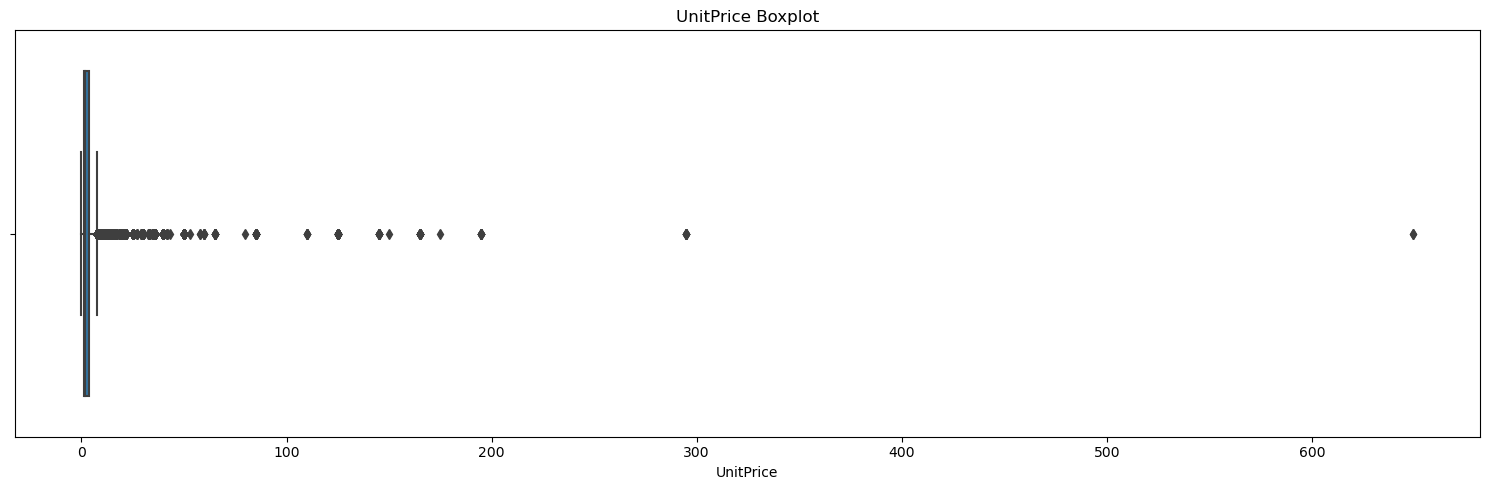

In [20]:
# Plot boxplot to visually identify outliers in 'UnitPrice'.
plt.figure(figsize=(15,5))

sns.boxplot(x=df['UnitPrice'])
plt.title('UnitPrice Boxplot')

plt.tight_layout()
plt.show()

After removing the alpha only stockcodes, it has resolved the big outlier of ~$39,000. I feel good about now moving forward with creating some additional variables such as *Amount (Monetary)*, *Recency*, and *Frequency*.

In [21]:
# Create an aggregated variable named 'Amount' using .loc to avoid SettingWithCopyWarning
df.loc[:, 'Amount'] = df['Quantity'] * df['UnitPrice']

df.head()

/var/folders/97/_c74g48s1xq_7yyvz41387qh0000gp/T/ipykernel_39906/2032635790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Amount'] = df['Quantity'] * df['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34


In [22]:
# Check for any errors or inconsistencies in 'Date' and 'Time' columns
# Verify unique values and their data types
date_unique_values = df['Date'].unique()
time_unique_values = df['Time'].unique()

# Summary of the Date and Time columns
date_summary = df['Date'].describe()
time_summary = df['Time'].describe()

(date_unique_values[:5], time_unique_values[:5], date_summary, time_summary)

(array([datetime.date(2010, 12, 1), datetime.date(2010, 12, 2),
        datetime.date(2010, 12, 3), datetime.date(2010, 12, 5),
        datetime.date(2010, 12, 6)], dtype=object),
 array([datetime.time(8, 26), datetime.time(8, 28), datetime.time(8, 34),
        datetime.time(8, 35), datetime.time(8, 45)], dtype=object),
 count         391328
 unique           305
 top       2011-11-06
 freq            3333
 Name: Date, dtype: object,
 count       391328
 unique         738
 top       13:35:00
 freq          1794
 Name: Time, dtype: object)

In [23]:
# Check for unique CustomerID values in the DataFrame
unique_customer_ids = df['CustomerID'].unique()

# Display the number of unique CustomerIDs
num_unique_customer_ids = len(unique_customer_ids)

num_unique_customer_ids

4336

In [24]:
# Prepare the Data for RFM Analysis
# Set a reference date for calculating Recency (e.g., day after the last date in the dataset)
reference_date = df['Date'].max() + pd.Timedelta(days=1)

# Group by CustomerID to calculate RFM metrics
rfm_df = df.groupby(['CustomerID', 'Country']).agg({
    'Date': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # 
    'Amount': 'sum'  # Monetary
}).reset_index()

# Rename columns for RFM
rfm_df.rename(columns={'Date': 'Recency', 'InvoiceNo': 'Frequency', 'Amount': 'Monetary'}, inplace=True)

# Display the RFM DataFrame
rfm_df.head()

,CustomerID,Country,Recency,Frequency,Monetary
0,12346.0,United Kingdom,326,1,77183.60
1,12347.0,Iceland,3,7,4310.00
2,12348.0,Finland,76,4,1437.24
3,12349.0,Italy,19,1,1457.55
4,12350.0,Norway,311,1,294.40


In [25]:
# Confirm 'Monetary' for CustomerID 12346.0
df[df['CustomerID'] == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Amount
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346.0,United Kingdom,2011-01-18,10:01:00,77183.6


<h3 style="color:blue;"><b>EXPLORATORY DATA ANALYSIS</h3>

array([[<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'UnitPrice'}>],
       [<Axes: title={'center': 'Amount'}>, <Axes: >]], dtype=object)

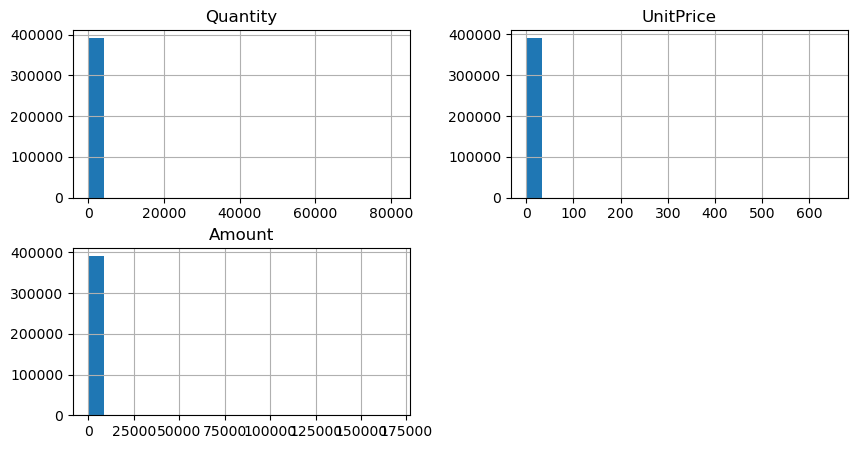

In [26]:
# Look at distributions of 'Quantity', 'UnitPrice', and 'Amount' to detect skewness and outliers.
df[['Quantity', 'UnitPrice', 'Amount']].hist(figsize=(10, 5), bins=20)

/var/folders/97/_c74g48s1xq_7yyvz41387qh0000gp/T/ipykernel_39906/3343875247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quantity_log'] = np.log1p(df['Quantity'])
/var/folders/97/_c74g48s1xq_7yyvz41387qh0000gp/T/ipykernel_39906/3343875247.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['UnitPrice_log'] = np.log1p(df['UnitPrice'])
/var/folders/97/_c74g48s1xq_7yyvz41387qh0000gp/T/ipykernel_39906/3343875247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

array([[<Axes: title={'center': 'Quantity_log'}>,
        <Axes: title={'center': 'UnitPrice_log'}>],
       [<Axes: title={'center': 'Amount_log'}>, <Axes: >]], dtype=object)

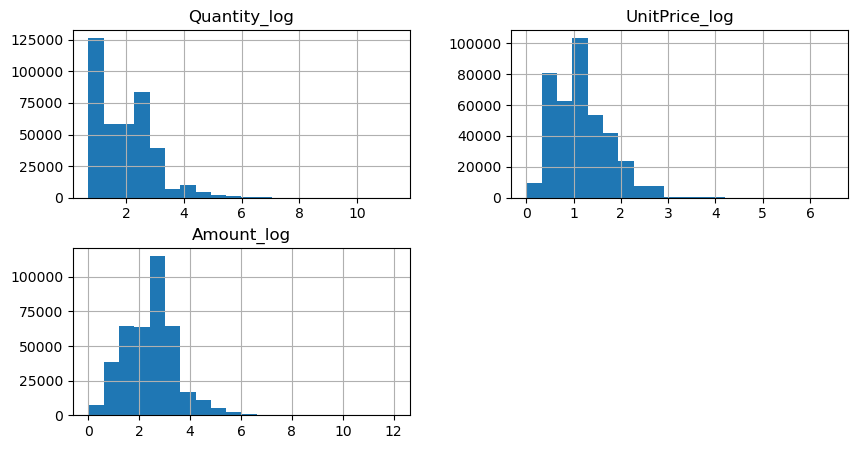

In [27]:
# It seems as most of the values are zero or near-zero indicating a small range, leading to a single, dense bin.
# Use log transformation to normalize the data.

df['Quantity_log'] = np.log1p(df['Quantity'])
df['UnitPrice_log'] = np.log1p(df['UnitPrice'])
df['Amount_log'] = np.log1p(df['Amount'])

df[['Quantity_log', 'UnitPrice_log', 'Amount_log']].hist(figsize=(10, 5), bins=20)


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


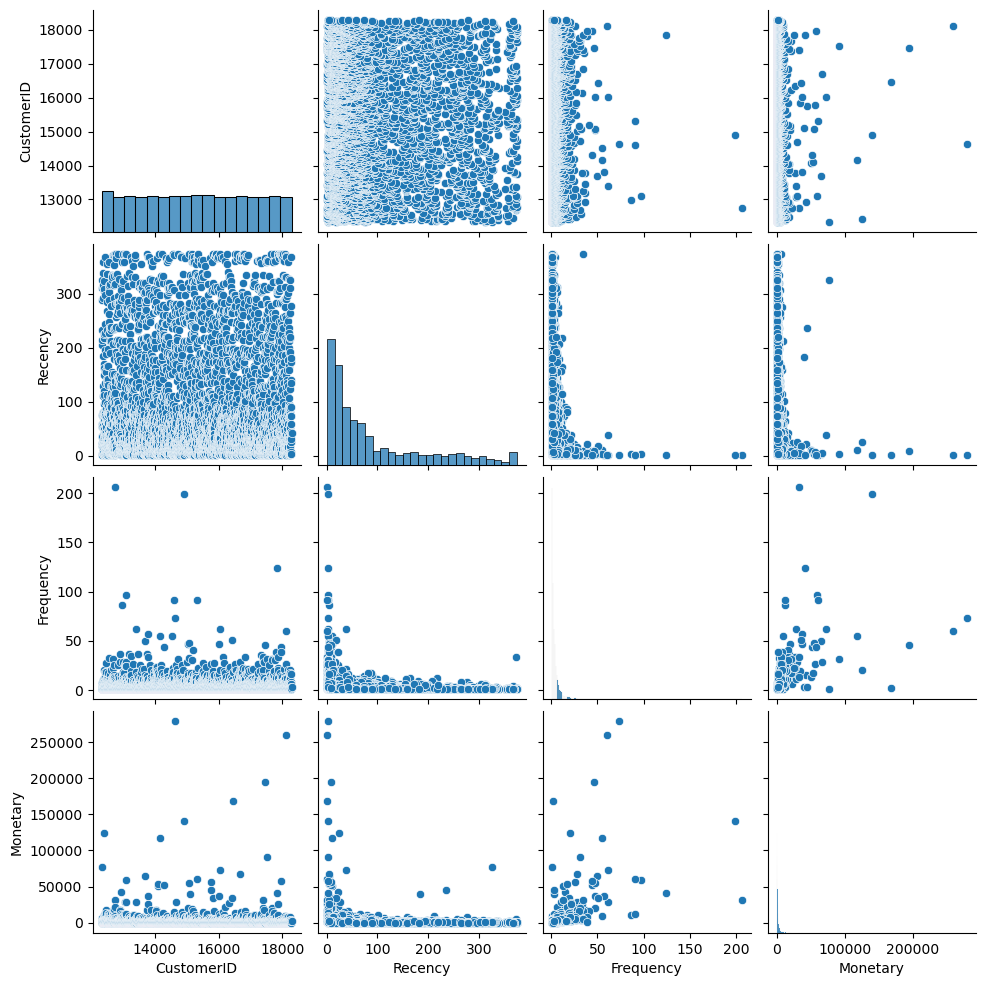

In [28]:
# Pairplot to understand relationships between 'Recency', 'Frequency', and 'Monetary' (Amount).
# Create the pairplot
pairplot = sns.pairplot(rfm_df)

# Manually adjust the layout to prevent the warning
plt.show()


<Axes: >

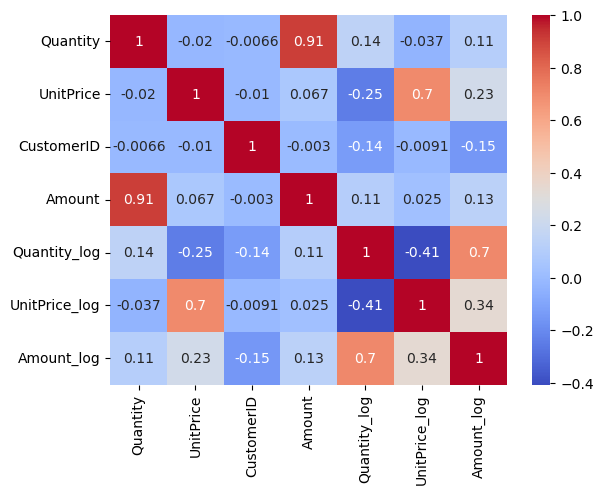

In [29]:
# Display a heatmap to explore correlations between numerical values and identify relationships.
# Filter numeric columns only
numeric_df = df.select_dtypes(include=['number'])

# Display correlation heatmap.
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')

array([[<Axes: title={'center': 'Frequency'}>,
        <Axes: title={'center': 'Recency'}>],
       [<Axes: title={'center': 'Monetary'}>, <Axes: >]], dtype=object)

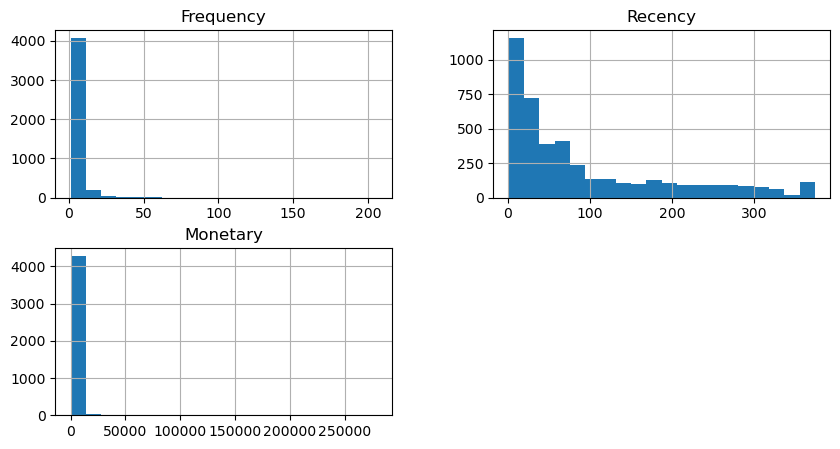

In [30]:
# Look at distributions of 'Frequency', 'Recency', and 'Monetary' to detect skewness and outliers.
rfm_df[['Frequency', 'Recency', 'Monetary']].hist(figsize=(10, 5), bins=20)

In [31]:
# Use log transformation to normalize the data to address the right skewness.
rfm_df['Frequency_log'] = np.log1p(rfm_df['Frequency'])
rfm_df['Recency_log'] = np.log1p(rfm_df['Recency'])
rfm_df['Monetary_log'] = np.log1p(rfm_df['Monetary'])

In [32]:
# Standardize values to bring them to a similar scale. Normally distributed data is assumed for K-means Clustering, so this will be used
# during model creation and training.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Frequency_log', 'Recency_log', 'Monetary_log']])

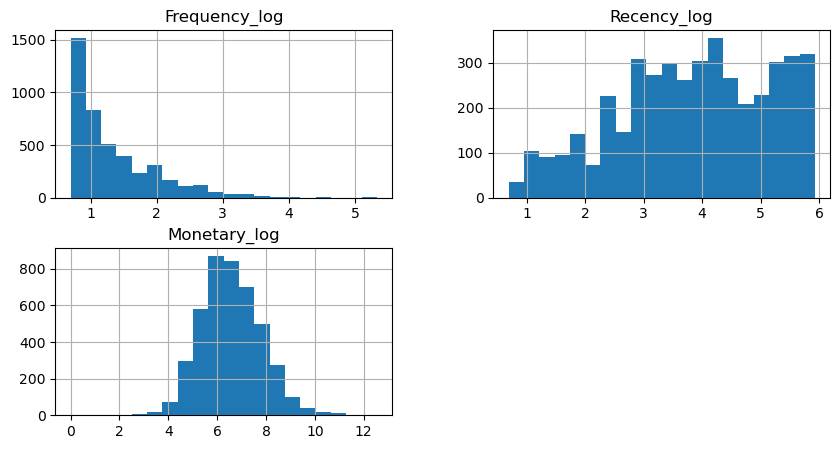

In [33]:
# Replot histograms after log transformation and scaling.
rfm_df[['Frequency_log', 'Recency_log', 'Monetary_log']].hist(figsize=(10, 5), bins=20)
plt.show()

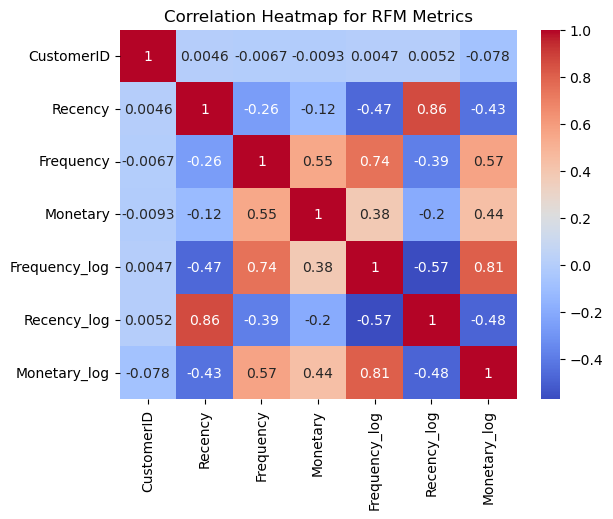

In [34]:
# Display correlation heatmap.
# Drop the 'Country' column and select only numeric columns
rfm_df_numeric = rfm_df.select_dtypes(include=['number'])

# Display the correlation heatmap for numeric columns
sns.heatmap(rfm_df_numeric.corr(), annot=True, cmap='coolwarm')

# Show the plot
plt.title('Correlation Heatmap for RFM Metrics')
plt.show()

<Axes: xlabel='Date'>

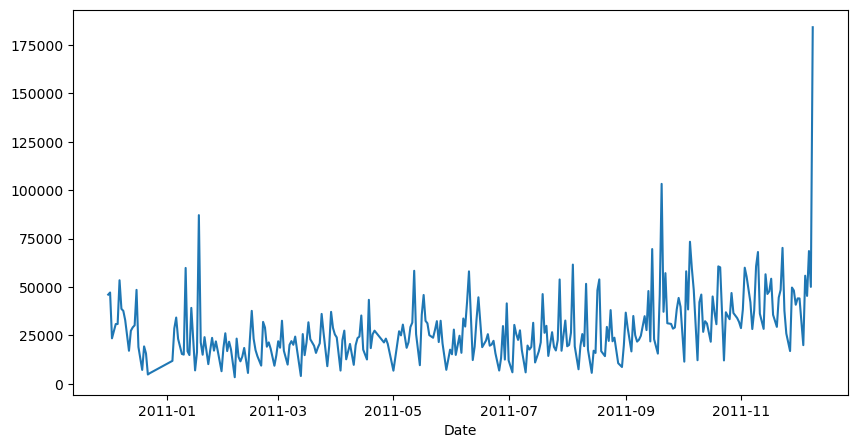

In [35]:
# Plot the sales over time to identify trends and seasonality.
df.groupby('Date')['Amount'].sum().plot(kind='line', figsize=(10,5))

We see a significant spike during December (most likely for the Christmas holiday) and late January (which could be related to fiscal budgets being approved).

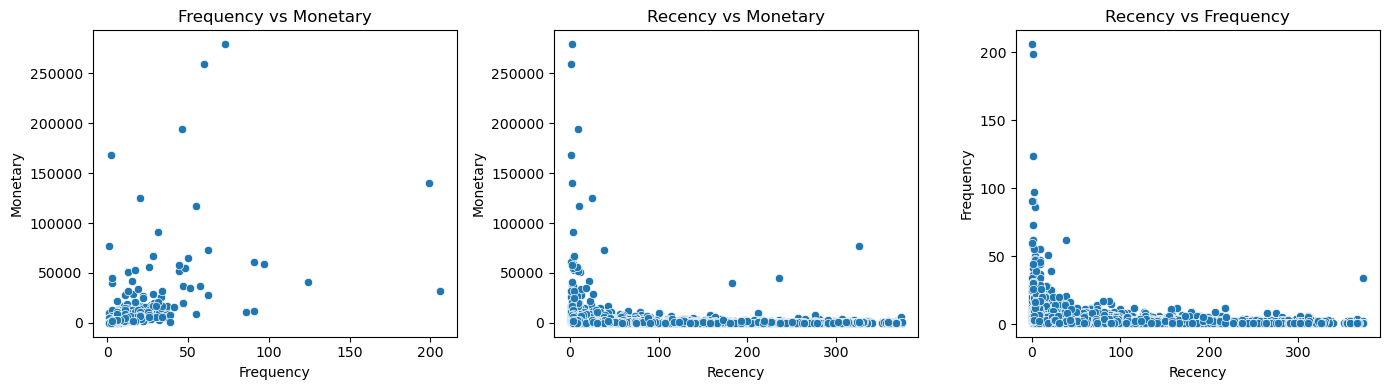

In [36]:
# Scatter plot for Frequency vs Monetary
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x='Frequency', y='Monetary', data=rfm_df)
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')

# Scatter plot for Recency vs Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(x='Recency', y='Monetary', data=rfm_df)
plt.title('Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')

# Scatter plot for Recency vs Frequency
plt.subplot(1, 3, 3)
sns.scatterplot(x='Recency', y='Frequency', data=rfm_df)
plt.title('Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Frequency vs Monetary:**  There seems to be a slight positive trend between Frequency and Monetary, meaning that customers who buy more often also tend to spend more. However, the trend is weak, indicating that frequency alone does not strongly predict spending.

**Recency vs. Monetary:**  There appears to be a negative relationship between Recency and Monetary. Lower Recency (i.e., more recent activity) correlates with higher Monetary values, suggesting that customers who have spent a lot tend to be more recently active.

**Rececny vs. Frequency:**  There doesn’t appear to be a strong correlation between Recency and Frequency. Some customers may have purchased frequently in the past but haven't made a recent purchase, while others have made frequent purchases recently.

**Key Takeaways and Next Steps:**

**High-Value Customers:** 
The outliers with high Monetary and Frequency or low Recency are key customers to focus on. They are likely to be high-value and loyal, and targeted offers or rewards could help retain them.

**Segmentation Considerations:** 
The presence of distinct clusters, such as high frequency but low monetary value or high monetary but low recency, suggests different types of customer behavior. Clustering using K-means may help identify these segments more effectively and tailor marketing strategies accordingly.

**Outlier Handling:** 
The scatter plots reveal significant outliers in the Monetary and Frequency dimensions. Consider capping or removing outliers to ensure that they do not heavily influence the clustering process, which is based on distance calculations.

**Normalization and Clustering:** 
Since there is a mix of high and low values, it’s crucial to normalize the RFM metrics before applying clustering. The normalized values will ensure that no single metric dominates due to its scale, which is particularly important given the visible outliers.

<Axes: xlabel='Country'>

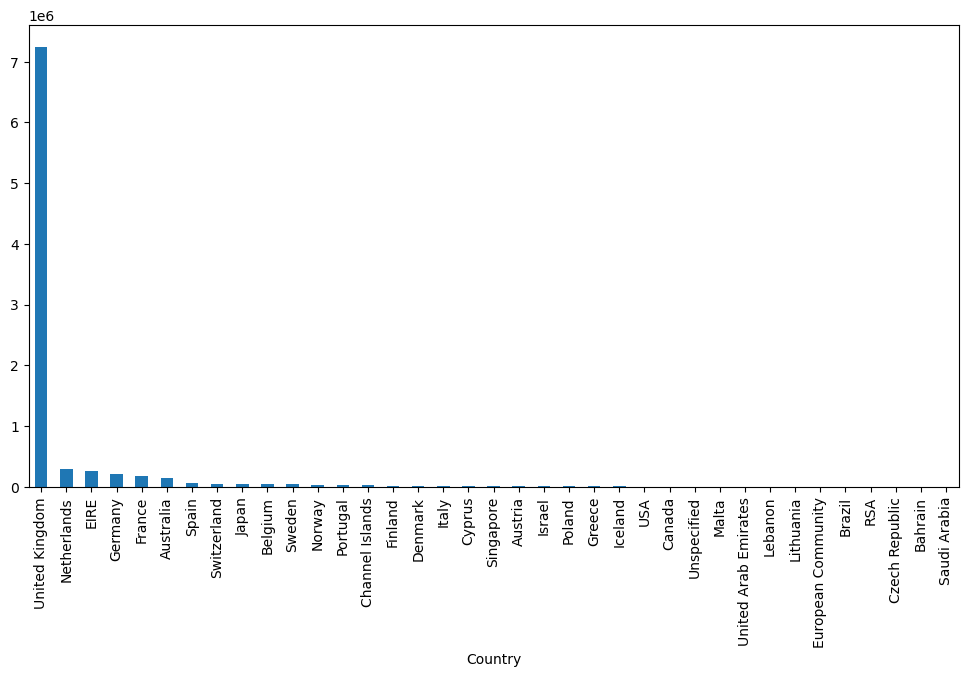

In [37]:
# Display a bar chart to understand sales by country
country_sales = df.groupby('Country')['Amount'].sum().sort_values(ascending=False)
country_sales.plot(kind='bar', figsize=(12, 6))

/var/folders/97/_c74g48s1xq_7yyvz41387qh0000gp/T/ipykernel_39906/3417511100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country_Group'] = df['Country'].apply(lambda x: 'United Kingdom' if x == 'United Kingdom' else 'Other Countries')


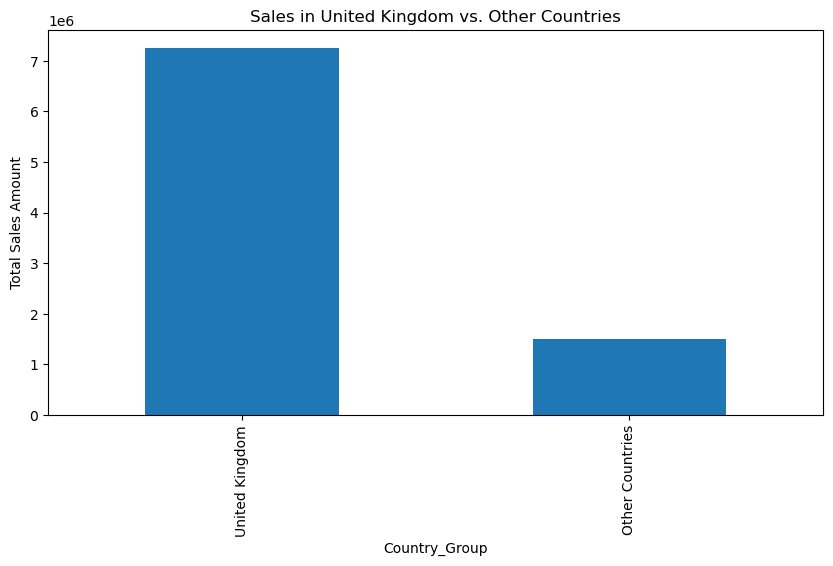

In [38]:
# Create a new column to group the UK and other countries
df['Country_Group'] = df['Country'].apply(lambda x: 'United Kingdom' if x == 'United Kingdom' else 'Other Countries')

# Group by the new 'Country_Group' column and sum the 'Amount'
country_group_sales = df.groupby('Country_Group')['Amount'].sum().sort_values(ascending=False)

# Plot the sales for 'United Kingdom' vs. 'Other Countries'
country_group_sales.plot(kind='bar', figsize=(10, 5), title='Sales in United Kingdom vs. Other Countries')

# Show the plot
plt.ylabel('Total Sales Amount')
plt.show()

**Geographic Analysis:** With the overwhelming majority of sales taking place in the UK, I will consider analyzing the UK versus all other countries as 1 group or possibly drop the other countries all together as they make up ~17% of the overall sales and there may not be enough data for the clustering algorithm.

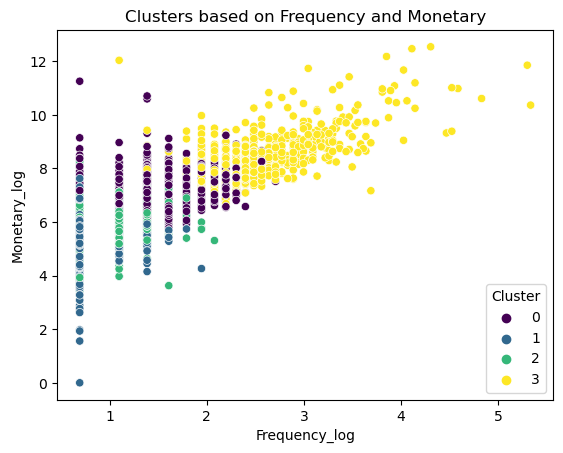

In [39]:
# Apply K-means clustering to all countries
kmeans = KMeans(n_clusters=4, random_state=42)  # Use the elbow method to determine n_clusters
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters if needed
sns.scatterplot(x='Frequency_log', y='Monetary_log', hue='Cluster', data=rfm_df, palette='viridis')
plt.title('Clusters based on Frequency and Monetary')
plt.show()

/var/folders/97/_c74g48s1xq_7yyvz41387qh0000gp/T/ipykernel_39906/499318849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_rfm_df['Cluster'] = kmeans_uk.fit_predict(uk_rfm_scaled)


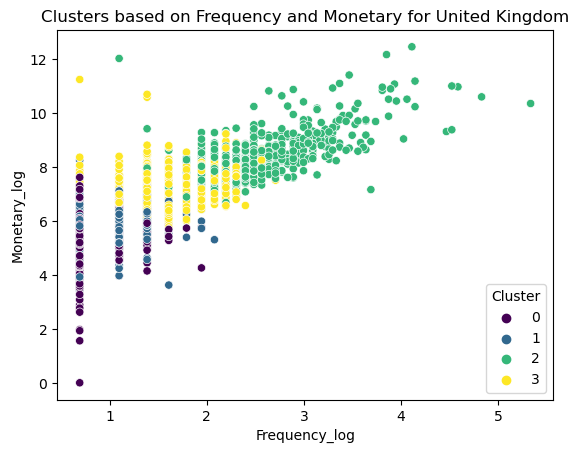

In [40]:
# Filter the DataFrame to only include records from the United Kingdom
uk_rfm_df = rfm_df[rfm_df['Country'] == 'United Kingdom']

# Filter the scaled data to only include the United Kingdom
uk_rfm_scaled = rfm_scaled[rfm_df['Country'] == 'United Kingdom']

# Apply K-means clustering to the United Kingdom data
kmeans_uk = KMeans(n_clusters=4, random_state=42)  # Use the elbow method to determine n_clusters
uk_rfm_df['Cluster'] = kmeans_uk.fit_predict(uk_rfm_scaled)

# Visualize clusters for the United Kingdom
sns.scatterplot(x='Frequency_log', y='Monetary_log', hue='Cluster', data=uk_rfm_df, palette='viridis')
plt.title('Clusters based on Frequency and Monetary for United Kingdom')
plt.show()

In [42]:
# Save the DataFrames to a pickle file
rfm_df.to_pickle('rfm_data.pkl')
uk_rfm_df.to_pickle('uk_rfm_df')